# Attention - on Gaussain peaks 

Q. If we train a Transformer regressor: Can Attention weights explain the model predicitons if we ask the model to predict a certain peak? 
    - Q. If yes how does the attention evolve with training?

- idea: Sergei V Kalinin and Utkarsh Pratiush
- Written by [Utkarsh Pratiush](https://github.com/utkarshp1161) in collaboration with ChatGPT 
    - Reach out for questions


In [ ]:
# pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
np.random.seed(42)
torch.manual_seed(42)

## Data Generation

Here, we define functions to generate synthetic spectra, each composed of three Gaussian peaks with added noise. The parameters (amplitude, position, width) of these peaks are randomly sampled from uniform distributions.

- Amplitude is treated as target value



In [ ]:
n_samples = 500
n_points = 100  # Number of points in each spectrum
x_range = np.linspace(0, 10, n_points)

def gaussian(x, amplitude, position, width):
    return amplitude * np.exp(-(x - position)**2 / (2 * width**2))

def generate_data(n_samples):
    spectra = []
    A1_values = []
    A2_values = []
    A3_values = []
    
    for _ in range(n_samples):
        A1 = np.random.uniform(0.5, 2.0)  # Amplitude of peak 1
        A2 = np.random.uniform(0.5, 2.0)
        A3 = np.random.uniform(0.5, 2.0)
        
        pos1 = np.random.uniform(2.0, 3.0)  # Position of peak 1
        pos2 = np.random.uniform(5.0, 6.0)  # Position of peak 2
        pos3 = np.random.uniform(7.5, 8.5)  # Position of peak 3
        
        width1 = np.random.uniform(0.2, 0.4)
        width2 = np.random.uniform(0.2, 0.4)
        width3 = np.random.uniform(0.2, 0.4)
        
        spectrum = (gaussian(x_range, A1, pos1, width1) + 
                   gaussian(x_range, A2, pos2, width2) + 
                   gaussian(x_range, A3, pos3, width3))
        
        # Add some noise
        noise = np.random.normal(0, 0.05, n_points)
        spectrum += noise
        
        spectra.append(spectrum)
        A1_values.append(A1)
        A2_values.append(A2)
        A3_values.append(A3)
    
    return np.array(spectra), np.array(A1_values), np.array(A2_values), np.array(A3_values)

In [ ]:
# Example of generated spectra
spectra, A1, A2, A3 = generate_data(5)

plt.figure(figsize=(10, 6))
for i in range(len(spectra)):
    plt.plot(x_range, spectra[i], label=f'Spectrum {i+1}')
plt.xlabel('x')
plt.ylabel('Intensity')
plt.title('Example Spectra with 3 Gaussian Peaks')
plt.legend()
plt.show()

## Self-Attention Mechanism

The `SelfAttention` module computes attention weights, determining the importance of each point in the spectrum relative to others.  This is a crucial part of the Transformer architecture.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads
        self.to_qkv = nn.Linear(dim, dim * 3)
        self.to_out = nn.Linear(dim, dim)
        self.scale = self.head_dim ** -0.5
    
    def forward(self, x):
        b, n, _ = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(b, n, self.heads, self.head_dim).transpose(1, 2), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(b, n, -1)
        out = self.to_out(out)
        self.attention_weights = attn# Save attention weights for visualization
        return out

## Transformer Regressor

The `TransformerRegressor` module combines embedding, positional encoding, self-attention, and feedforward layers to predict the amplitude of a Gaussian peak from the input spectrum.

In [ ]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, heads=4):
        super().__init__()
        self.embedding = nn.Linear(1, hidden_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, input_dim, hidden_dim))
    
        self.attention = SelfAttention(hidden_dim, heads=heads)
        self.norm1 = nn.LayerNorm(hidden_dim)
    
        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.to_out = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        b, n = x.shape
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = x + self.pos_encoding
        attn_out = self.attention(x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        x = x.mean(dim=1)########## pooling
        out = self.to_out(x)
        return out

## Training Loop


In [ ]:
def visualize_attention(model, spectrum, epoch):
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    spectrum_tensor = torch.FloatTensor(spectrum).unsqueeze(0)

    with torch.no_grad():
        model.eval()
        _ = model(spectrum_tensor)
        attention_weights = model.attention.attention_weights.detach().cpu().numpy()

    avg_attention = attention_weights[0].mean(axis=0)
    attention_sum = avg_attention.sum(axis=0)
    attention_sum = attention_sum / attention_sum.max()  # Normalize

    fig, axs = plt.subplots(3, 1, figsize=(14, 12))

    # Plot 1: Input spectrum
    axs[0].plot(x_range, spectrum, color='blue')
    axs[0].set_title('Input Spectrum')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('Intensity')

    # Plot 2: Heatmap of attention
    sns.heatmap(avg_attention, cmap='viridis', ax=axs[1])
    axs[1].set_title(f'Attention Weights for EPOCH = {epoch}')
    axs[1].set_xlabel('Position')
    axs[1].set_ylabel('Query Position')

    # Plot 3: Overlay attention sum with spectrum
    axs[2].plot(x_range, spectrum, label='Spectrum', color='blue')
    axs[2].plot(x_range, attention_sum, label='Attention Weight', color='red', alpha=0.7)
    axs[2].set_title(f'Spectrum with Attention Weights for EPOCH = {epoch}')
    axs[2].set_xlabel('x')
    axs[2].set_ylabel('Intensity / Attention')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    return attention_sum

Starting EPCOH = 0
Sample 1 - True A1: 1.2577
Predicted A1: -0.0789


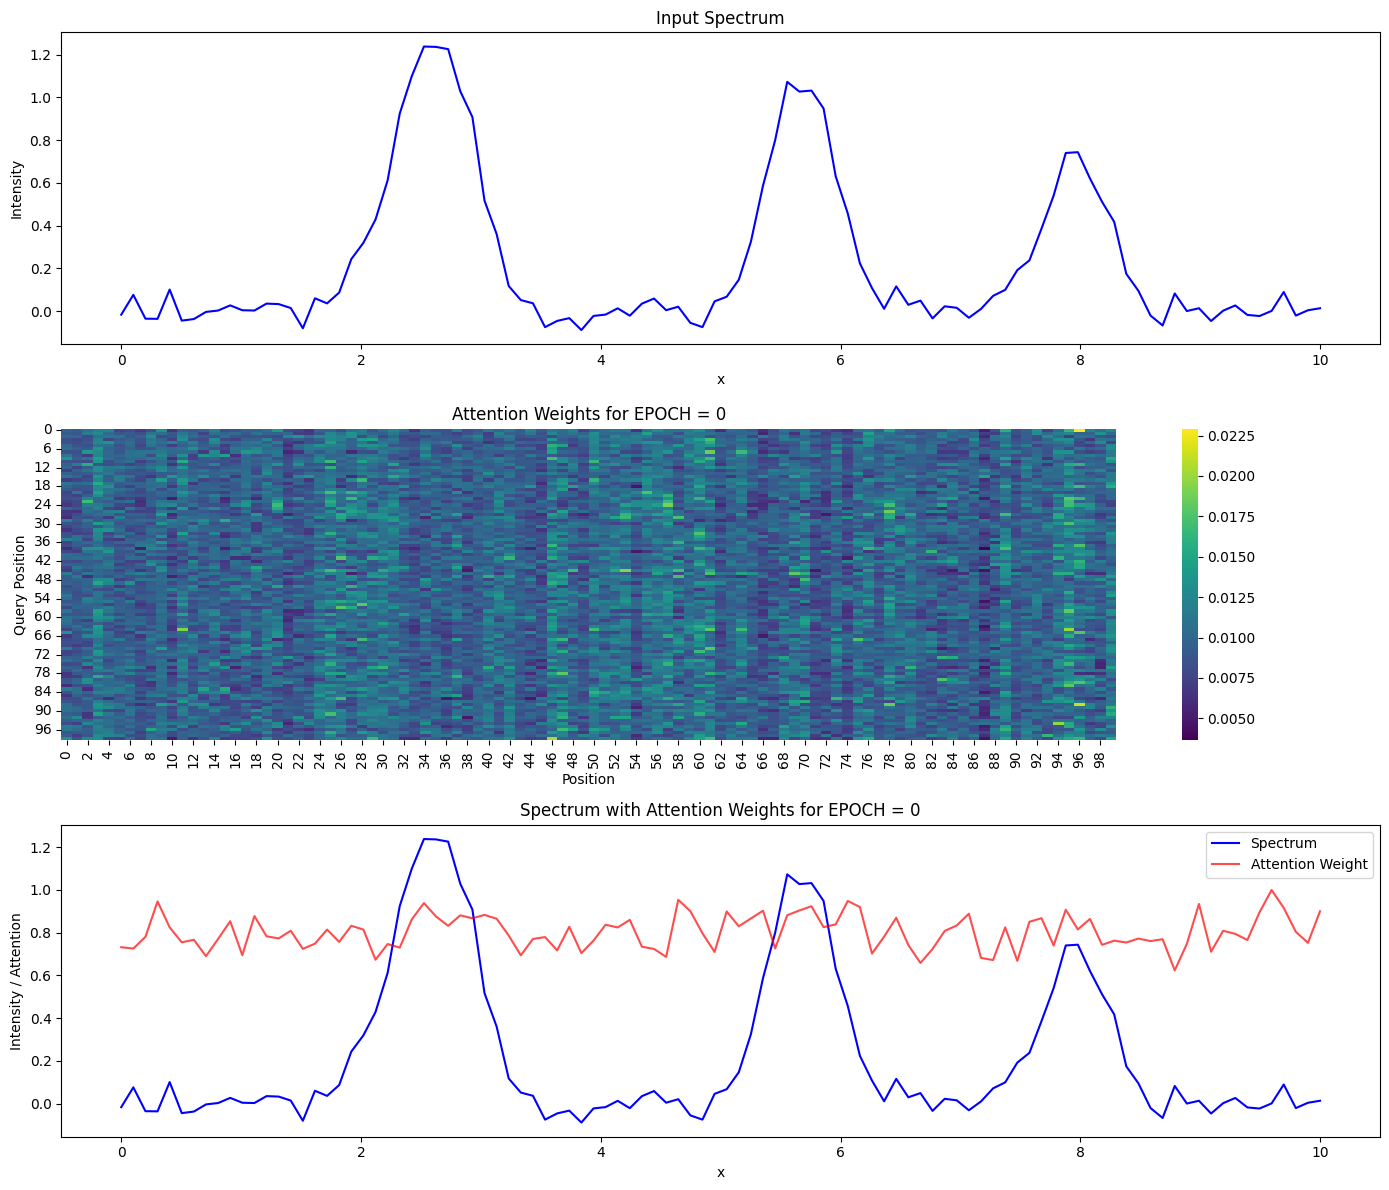

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [0.93878317 0.88182276 0.92386496 0.81535107]

Epoch 1/10, Train Loss: 0.4615, Val Loss: 0.2597
Starting EPCOH = 1
Sample 1 - True A1: 1.2577
Predicted A1: 0.9182


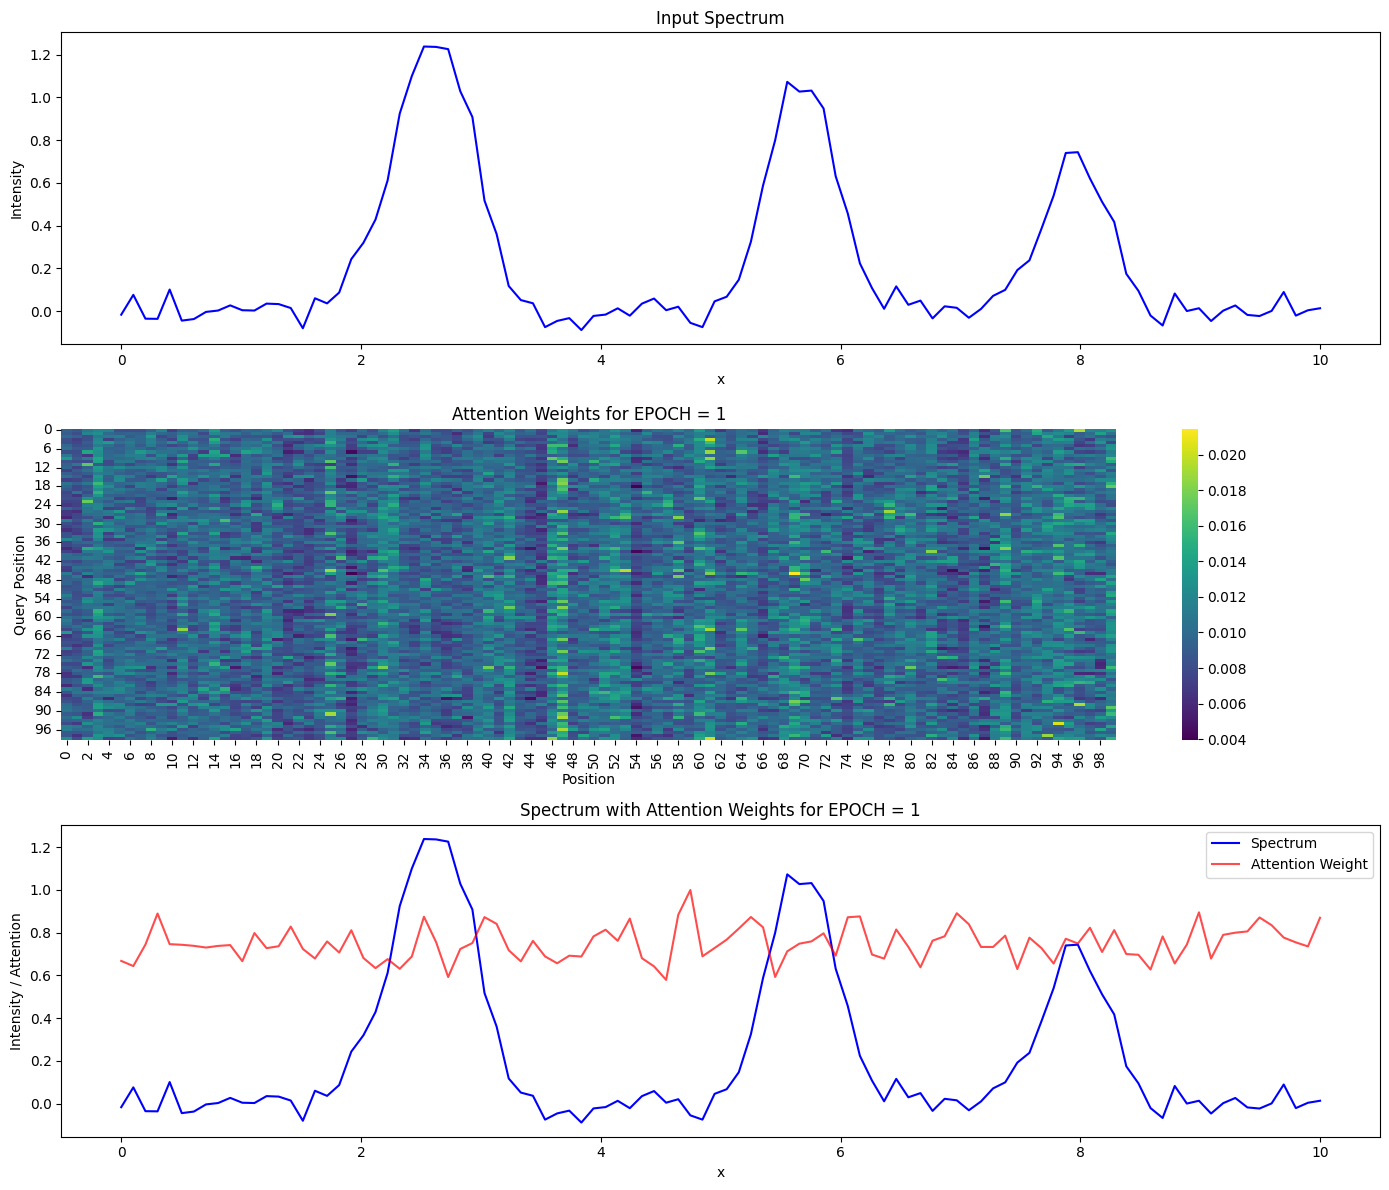

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [0.8748925  0.7127084  0.75933677 0.74934953]

Epoch 2/10, Train Loss: 0.2260, Val Loss: 0.2045
Starting EPCOH = 2
Sample 1 - True A1: 1.2577
Predicted A1: 1.3260


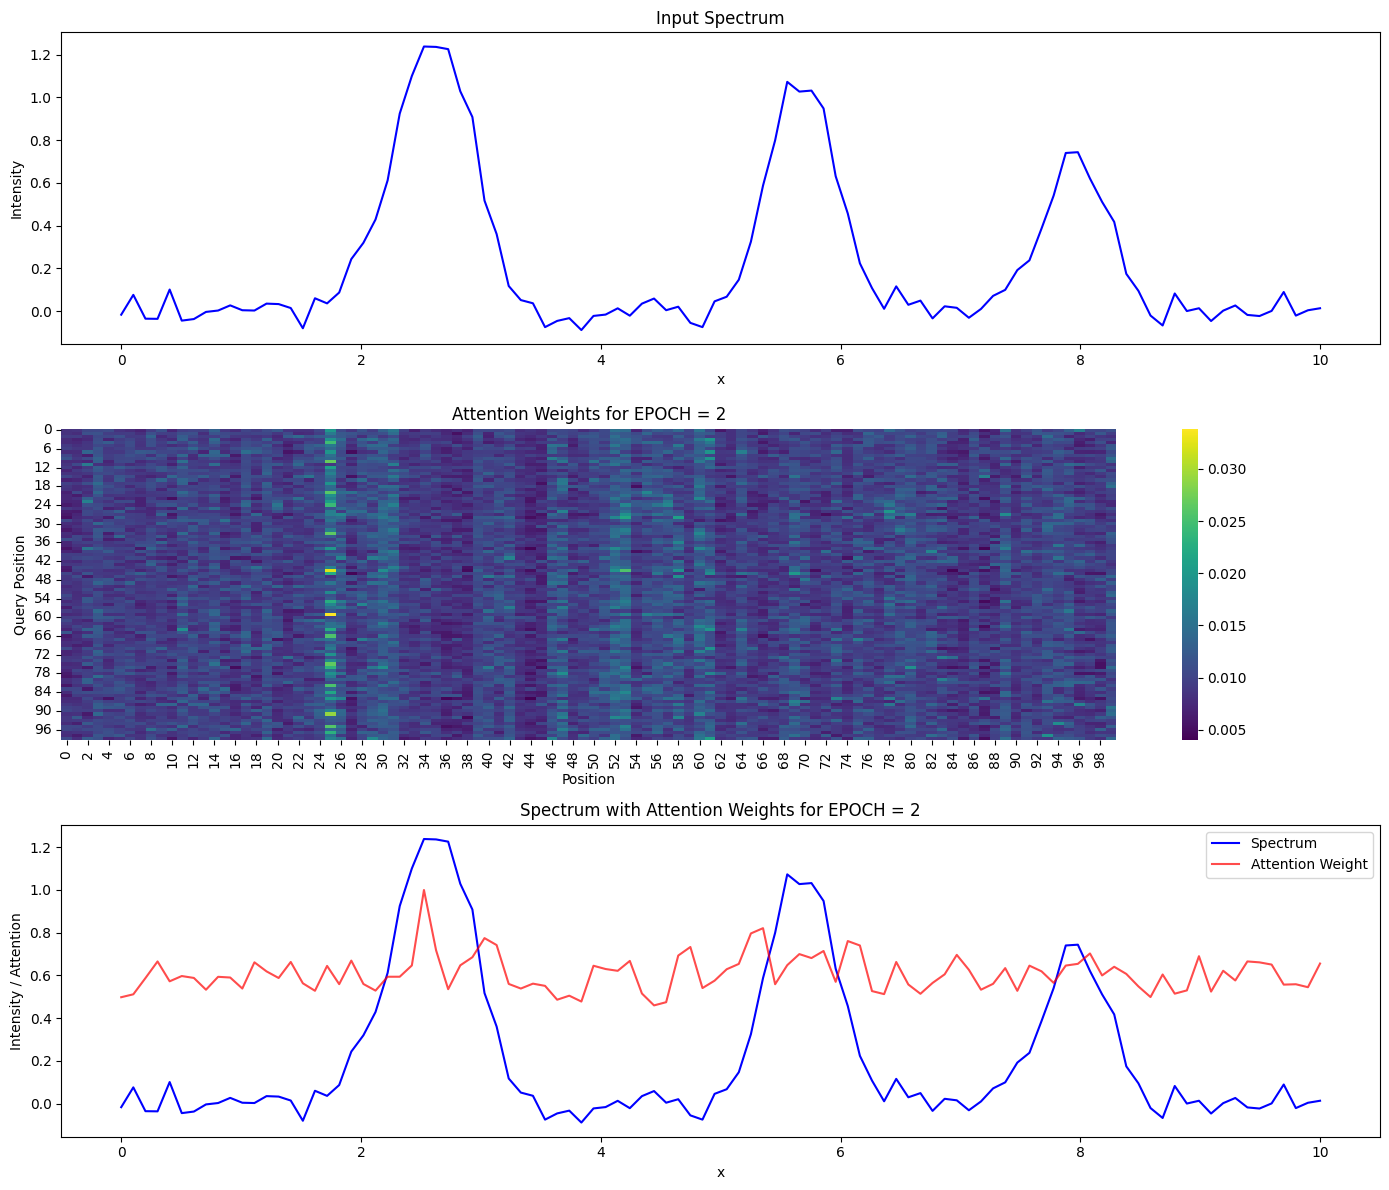

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [1.         0.6479555  0.68124616 0.6541322 ]

Epoch 3/10, Train Loss: 0.1764, Val Loss: 0.1818
Starting EPCOH = 3
Sample 1 - True A1: 1.2577
Predicted A1: 1.2293


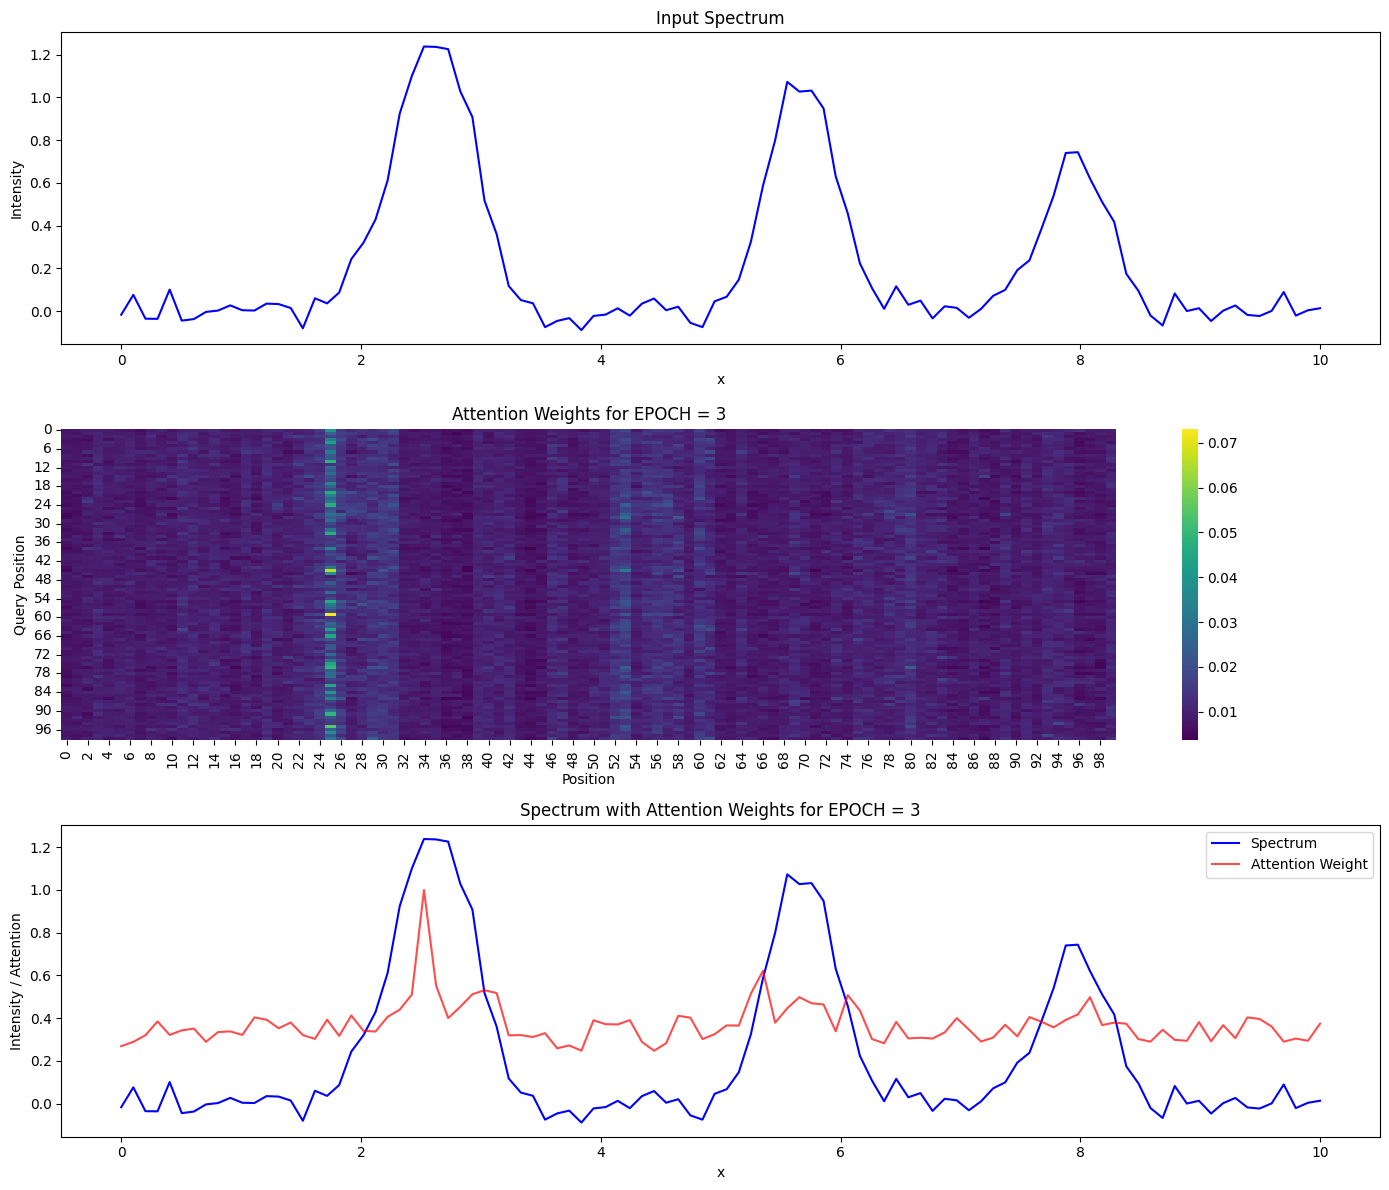

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [1.         0.44606918 0.46971563 0.4174886 ]

Epoch 4/10, Train Loss: 0.1544, Val Loss: 0.1526
Starting EPCOH = 4
Sample 1 - True A1: 1.2577
Predicted A1: 1.1585


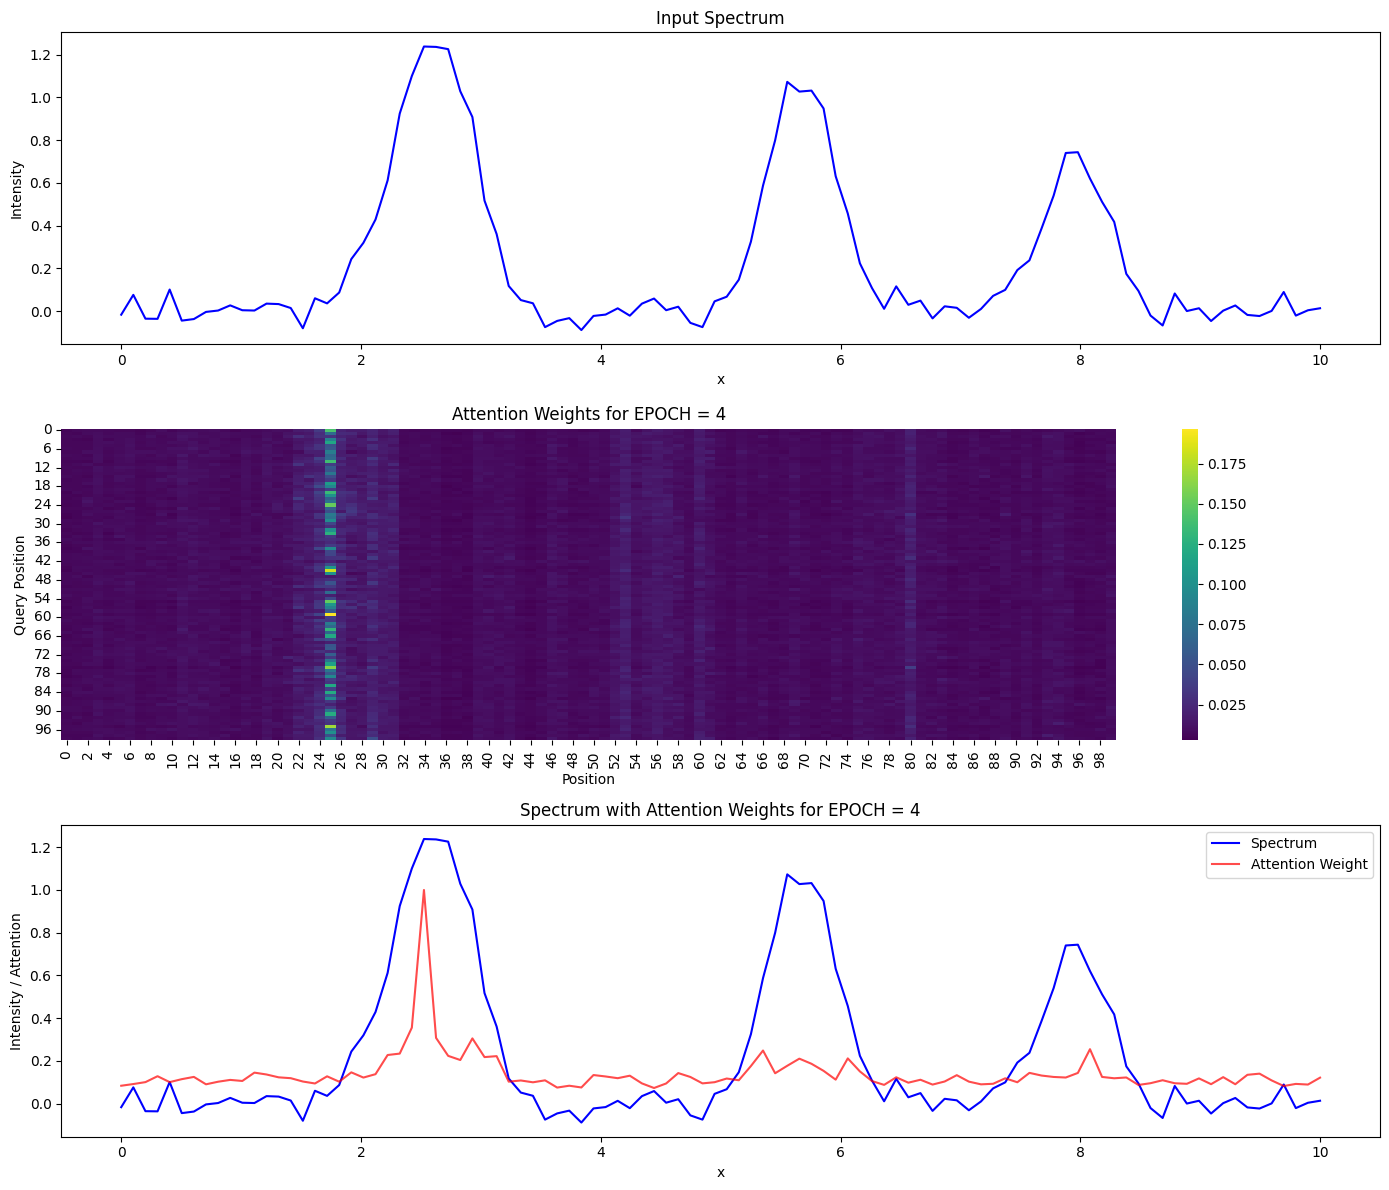

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [1.         0.17682634 0.18628284 0.14333943]

Epoch 5/10, Train Loss: 0.1039, Val Loss: 0.0730
Starting EPCOH = 5
Sample 1 - True A1: 1.2577
Predicted A1: 1.2618


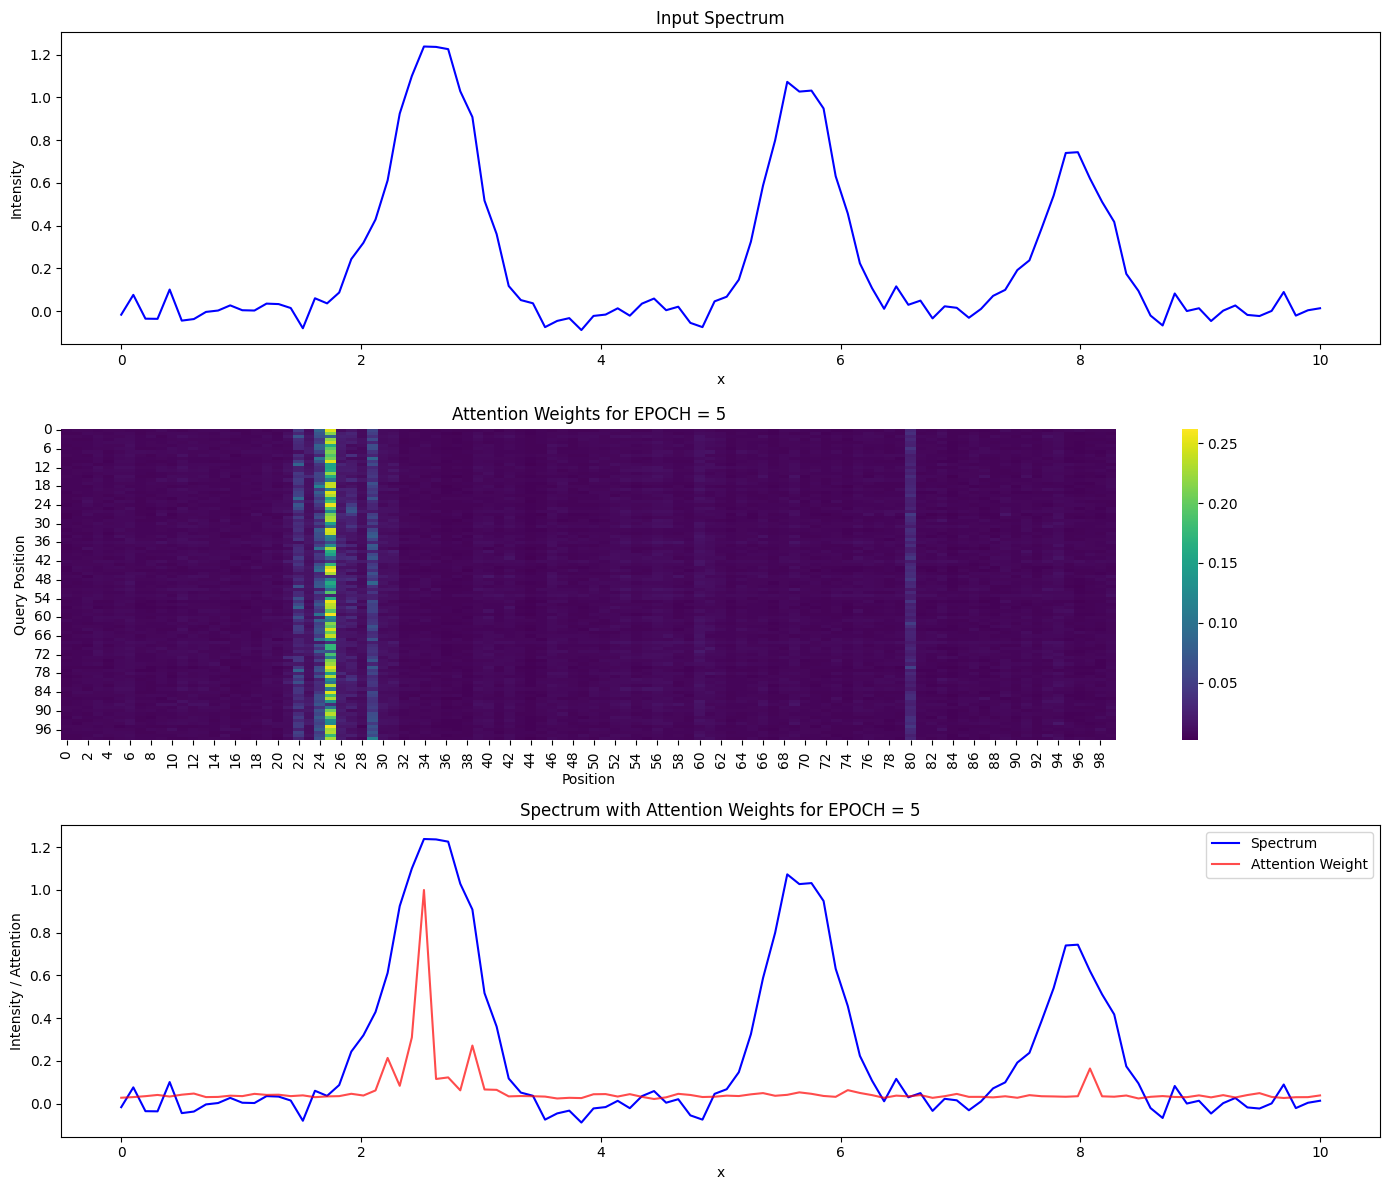

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [1.         0.04083132 0.04558965 0.03437481]

Epoch 6/10, Train Loss: 0.0437, Val Loss: 0.0260
Starting EPCOH = 6
Sample 1 - True A1: 1.2577
Predicted A1: 1.3666


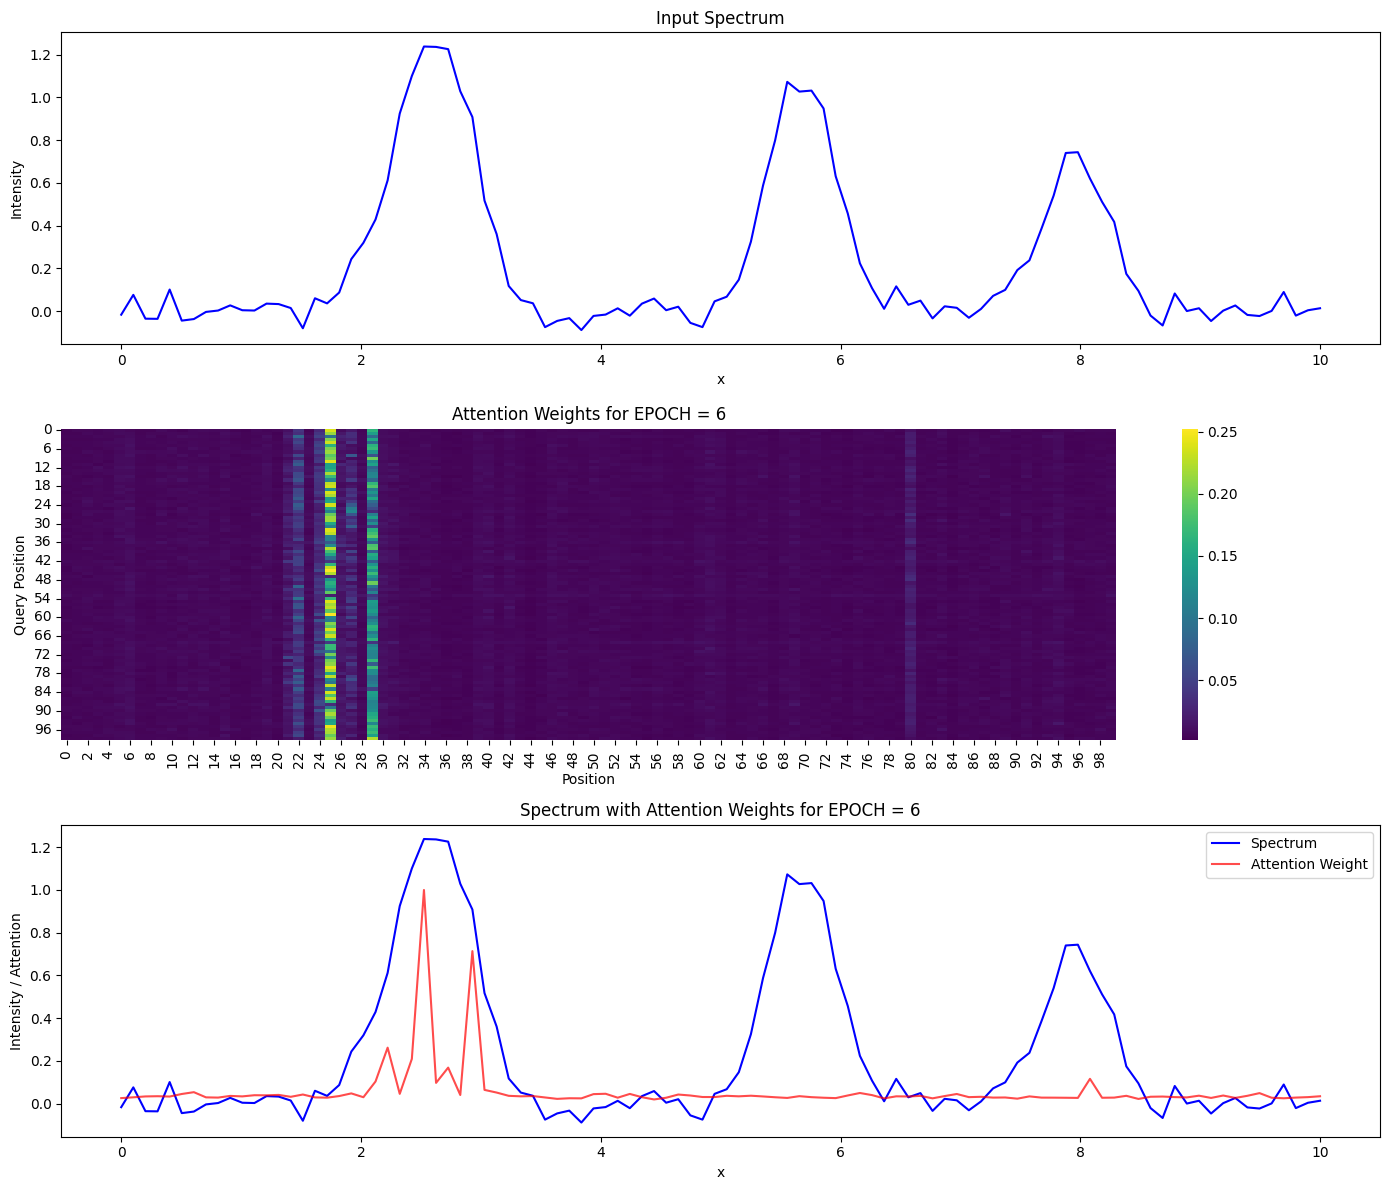

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [1.         0.02632498 0.02989729 0.0264515 ]

Epoch 7/10, Train Loss: 0.0178, Val Loss: 0.0191
Starting EPCOH = 7
Sample 1 - True A1: 1.2577
Predicted A1: 1.2599


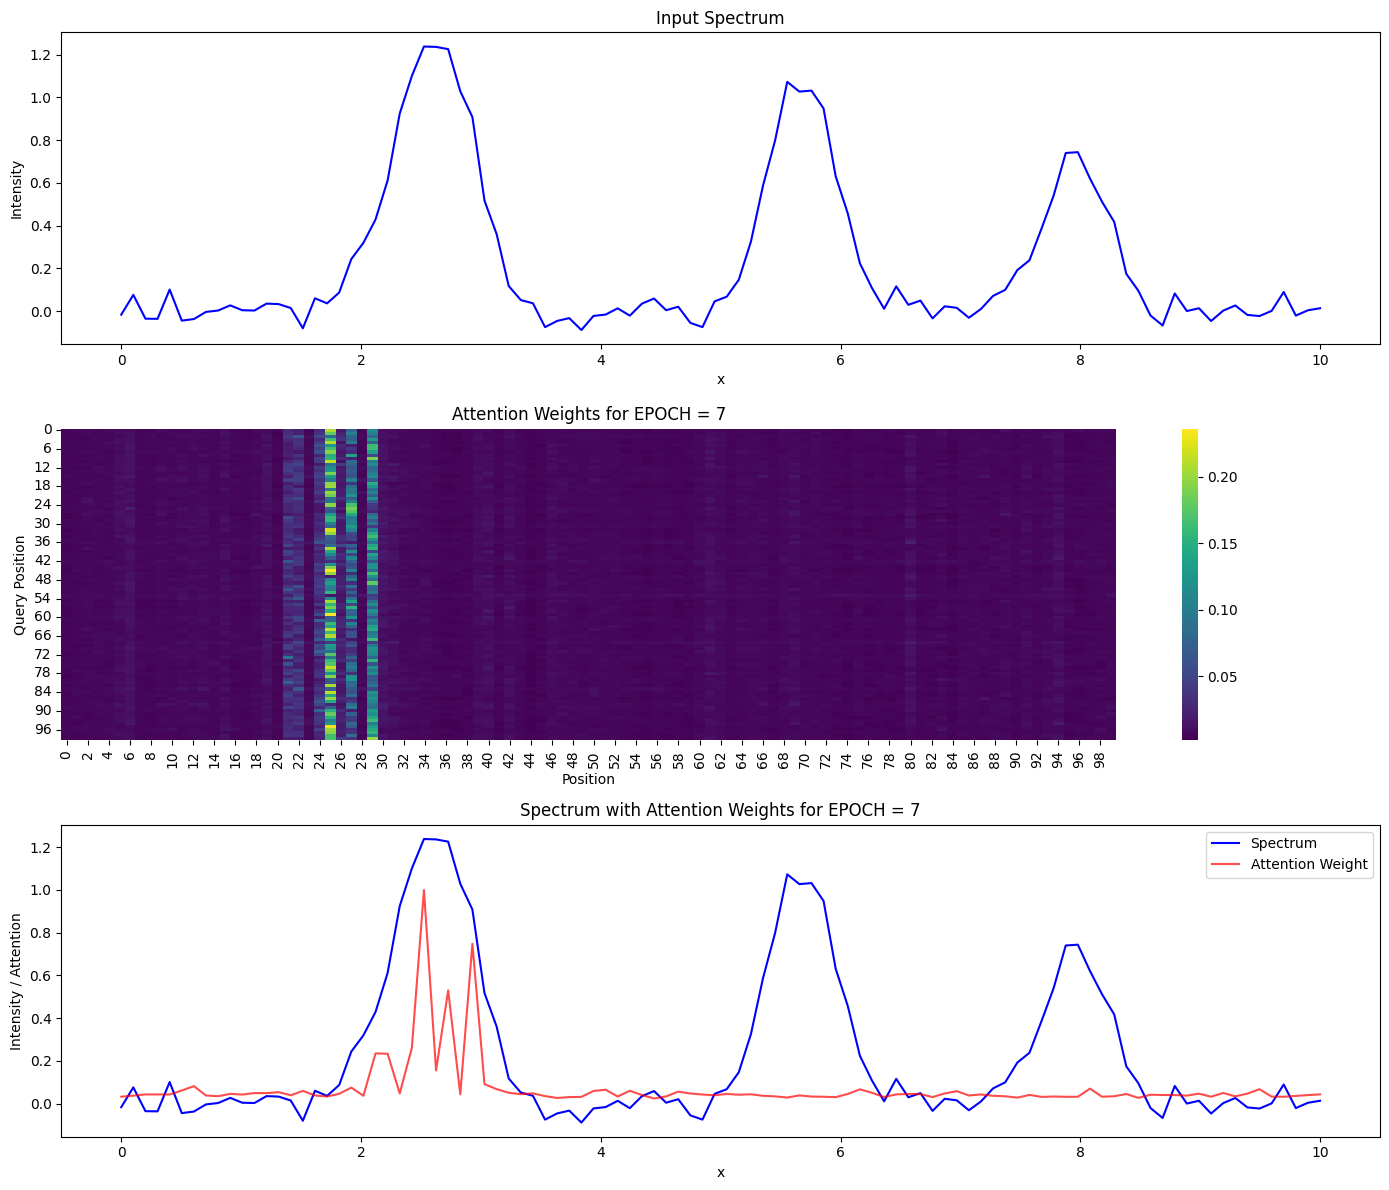

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [1.         0.02814987 0.03272576 0.03178682]

Epoch 8/10, Train Loss: 0.0153, Val Loss: 0.0132
Starting EPCOH = 8
Sample 1 - True A1: 1.2577
Predicted A1: 1.3076


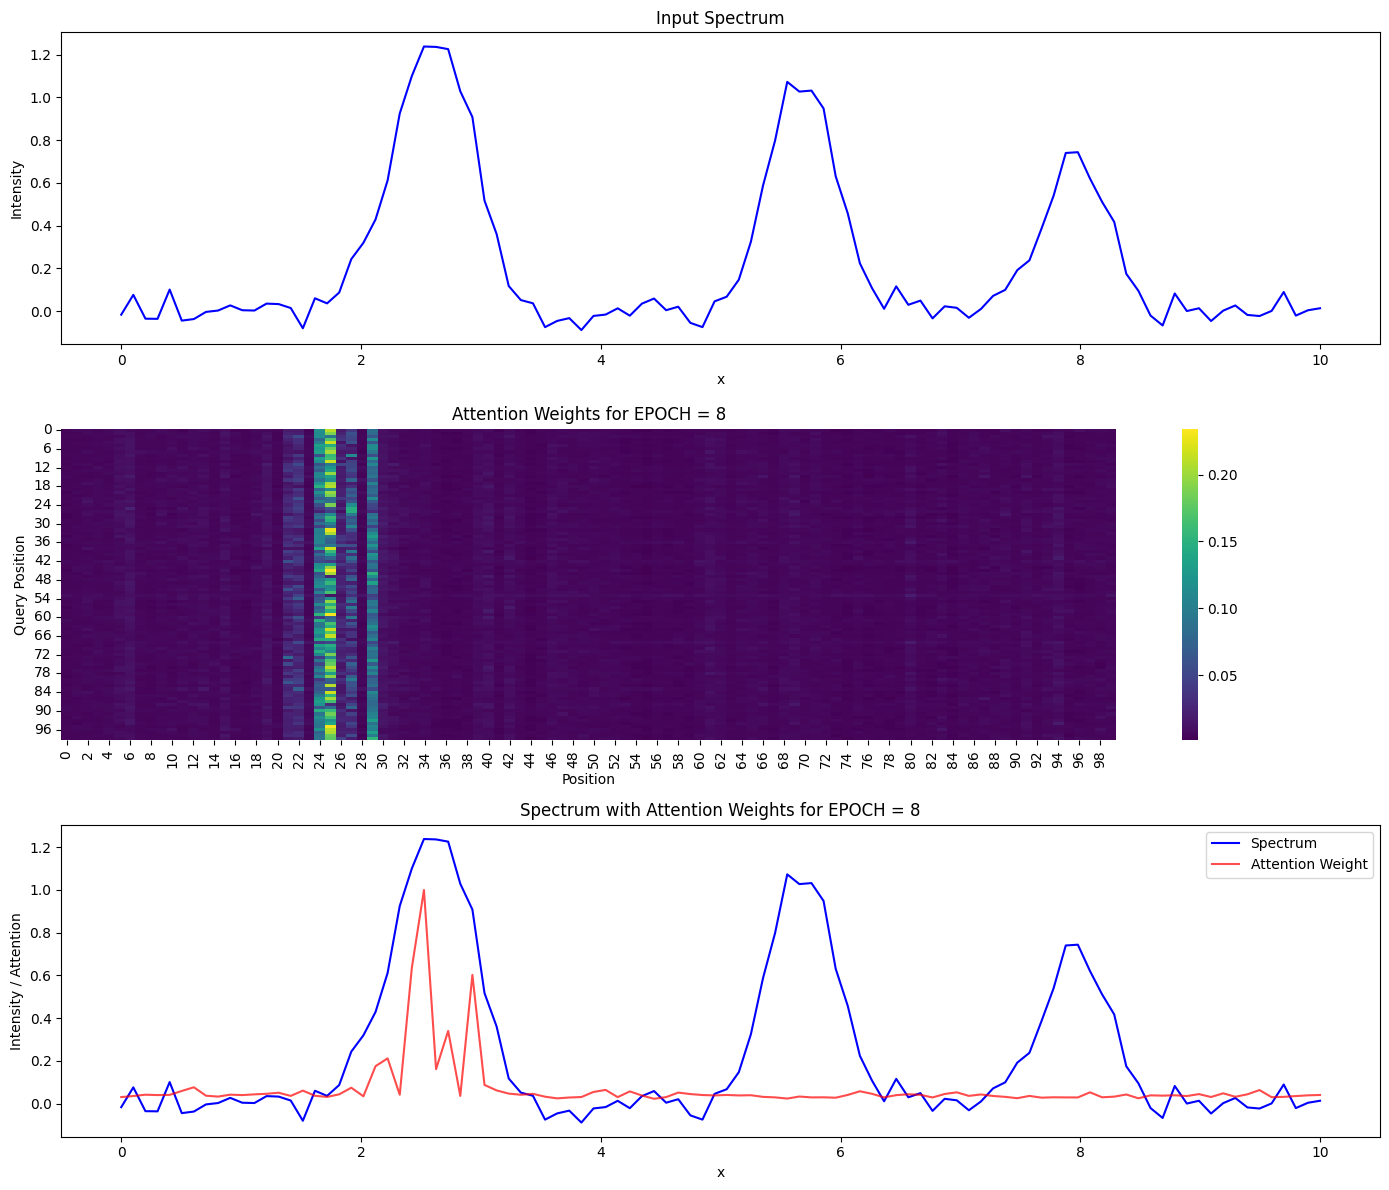

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [1.         0.02333033 0.02883564 0.02864286]

Epoch 9/10, Train Loss: 0.0096, Val Loss: 0.0098
Starting EPCOH = 9
Sample 1 - True A1: 1.2577
Predicted A1: 1.3066


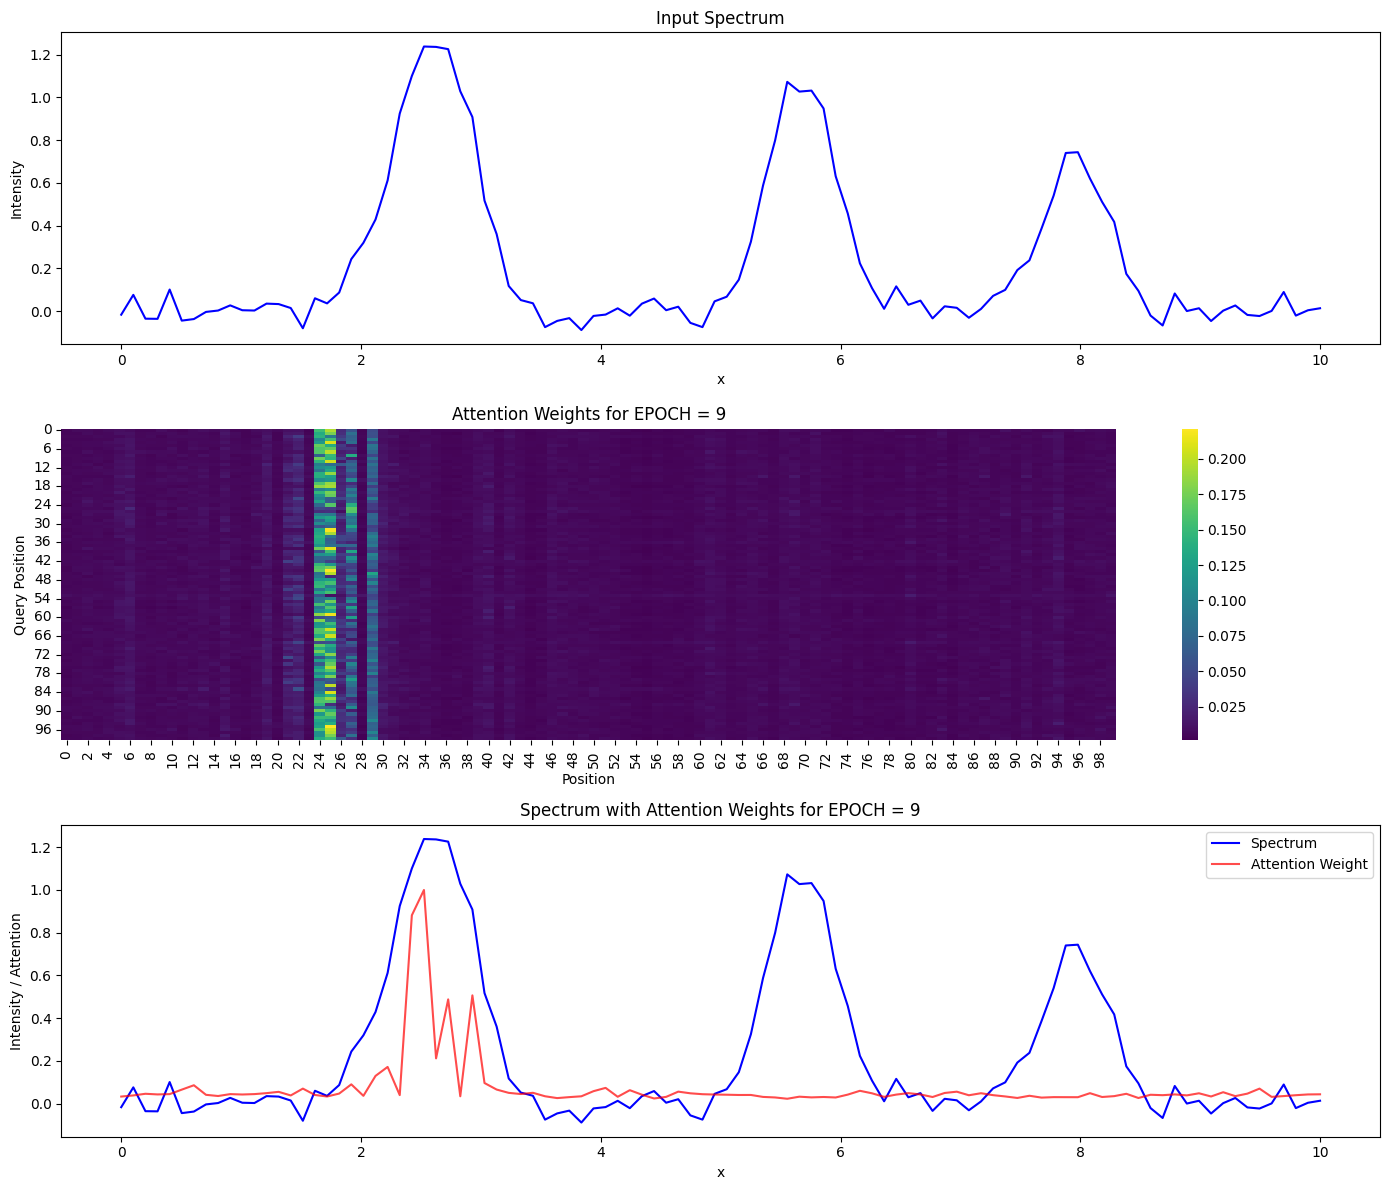

Peak positions: [2.52525253 5.55555556 5.75757576 7.97979798]
Attention at peaks: [1.         0.02243017 0.0288428  0.02971906]

Epoch 10/10, Train Loss: 0.0069, Val Loss: 0.0072


In [36]:
n_points = 100
model = TransformerRegressor(input_dim=n_points)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


n_epochs = 10 
train_losses = []
val_losses = []

# Generate data
X_train, A1_values, A2_values, A3_values = generate_data(n_samples)
X_val, A1_val, A2_val, A3_val = generate_data(100)

# Use A1 as the target peak
y_train = A1_values
y_val = A1_val

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

for epoch in range(n_epochs):
    print(f"Starting EPCOH = {epoch}")
    # Test the model on a few examples from the validation set on this epoch
    if epoch % 1 == 0: ######## see attention evolution
        for i in range(1):
            print(f"Sample {i+1} - True A1: {y_val[i]:.4f}")
            spectrum = X_val[i]

            with torch.no_grad():
                model.eval()
                pred = model(torch.FloatTensor(spectrum).unsqueeze(0))
                print(f"Predicted A1: {pred.item():.4f}")
            attention_weights = visualize_attention(model, spectrum, epoch)
            from scipy.signal import find_peaks
            peaks, _ = find_peaks(spectrum, height=0.3)

            print(f"Peak positions: {x_range[peaks]}")
            print(f"Attention at peaks: {attention_weights[peaks]}")
            print()
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
    
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()

    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Post training Attention Visualization 

This section visualizes the attention weights to understand which parts of the spectrum the model focuses on when making predictions.

Sample 1 - True A1: 1.8022
Predicted A1: 1.7911


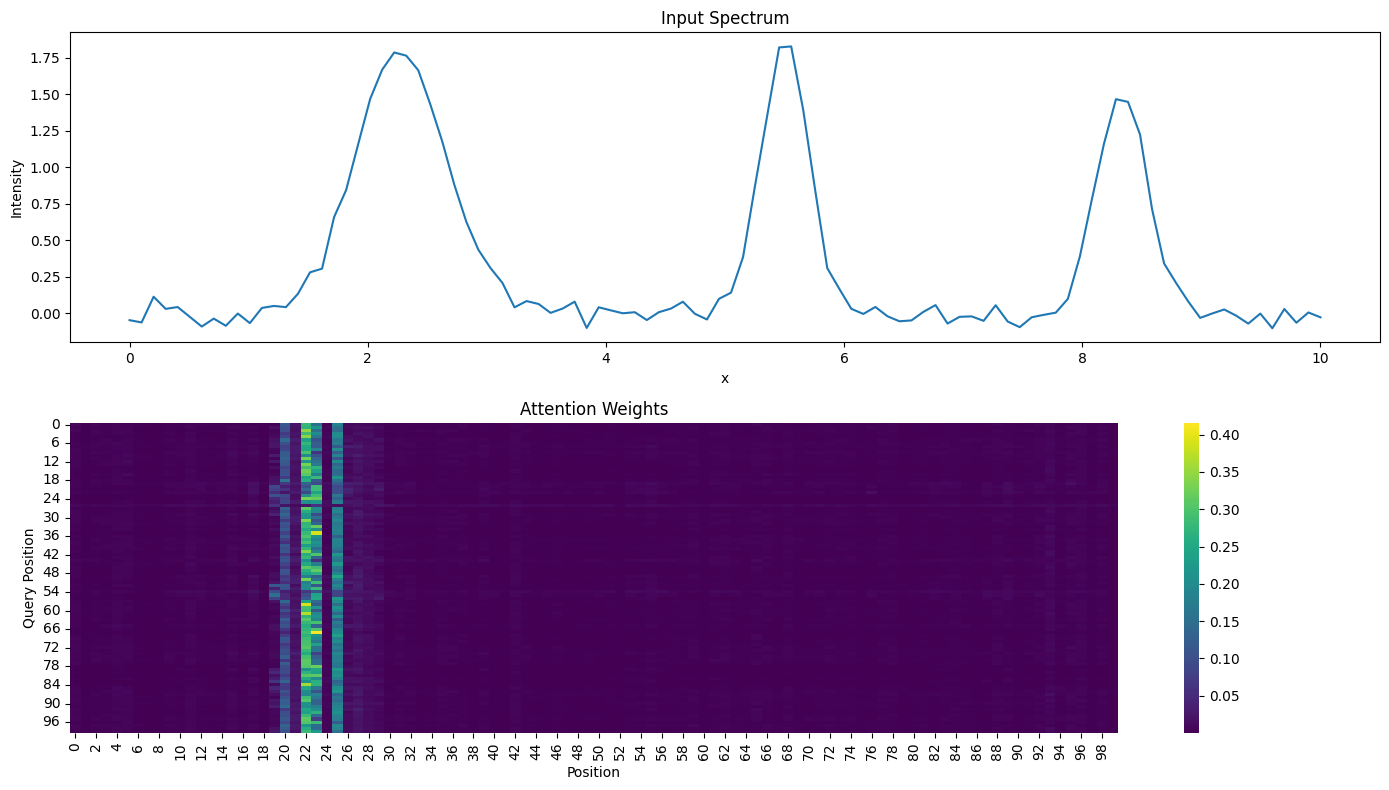

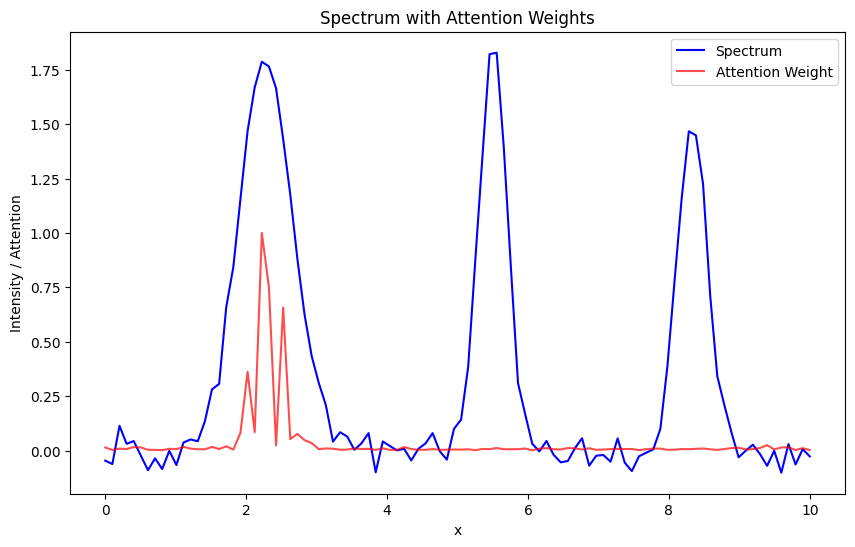

Peak positions: [2.22222222 5.55555556 8.28282828]
Attention at peaks: [1.         0.01218572 0.00652453]

Sample 2 - True A1: 0.6466
Predicted A1: 0.7110


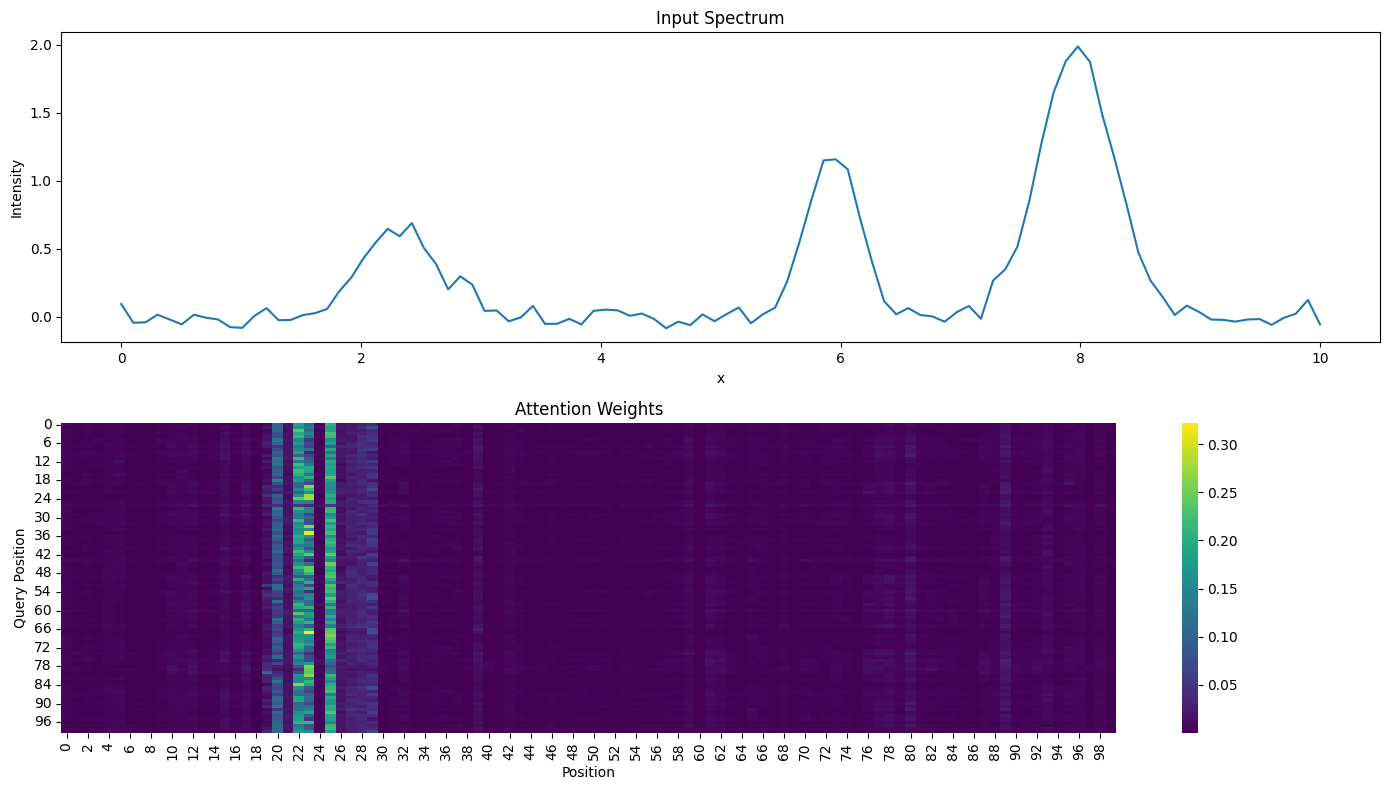

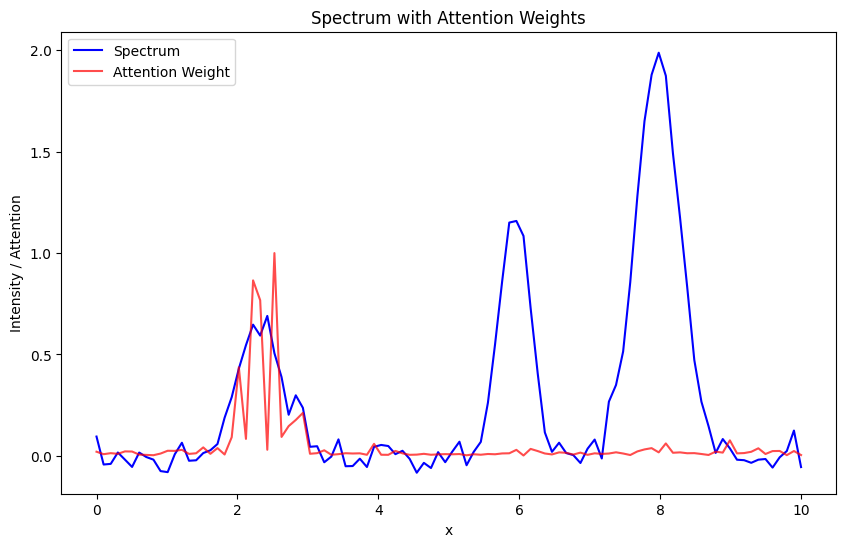

Peak positions: [2.22222222 2.42424242 5.95959596 7.97979798]
Attention at peaks: [0.8655093  0.03032447 0.02990424 0.01753514]

Sample 3 - True A1: 1.4412
Predicted A1: 1.4652


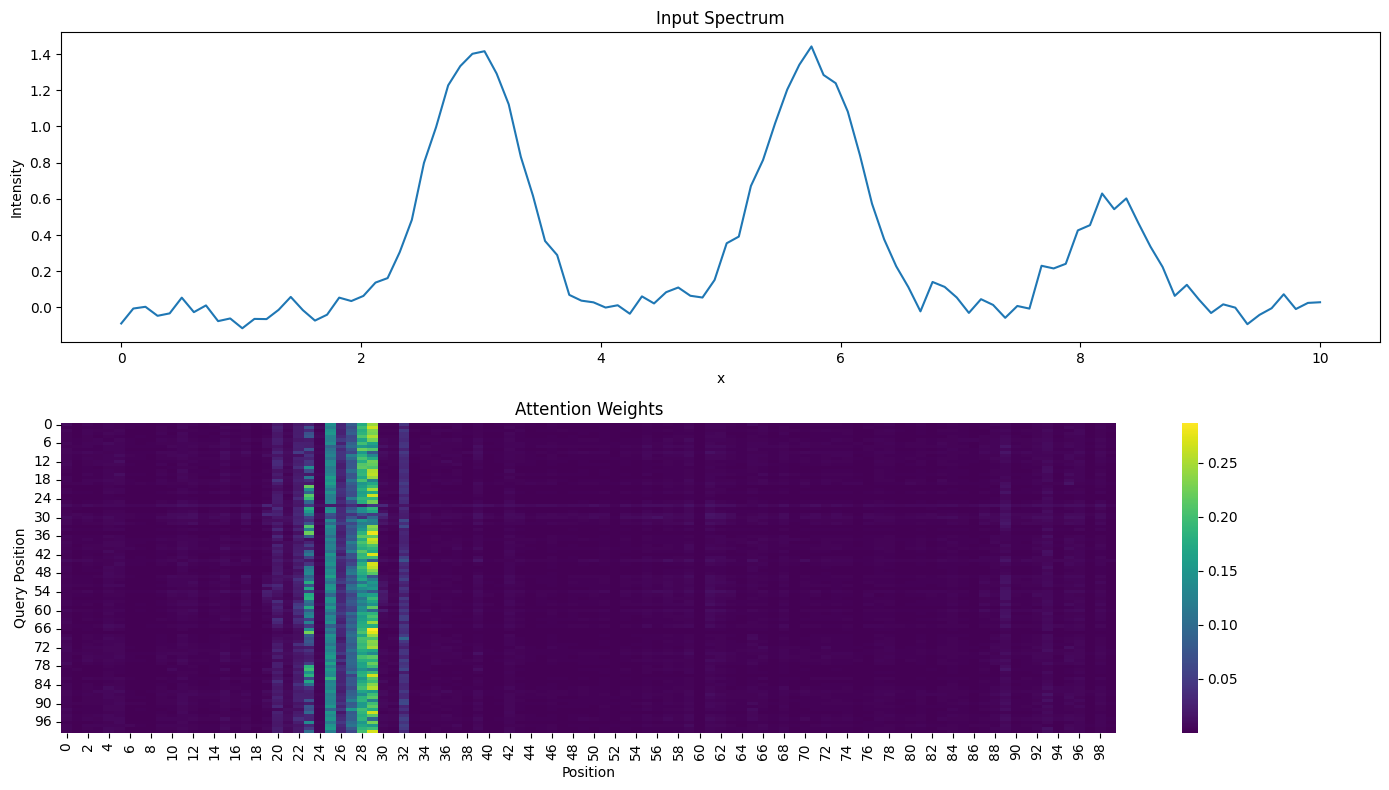

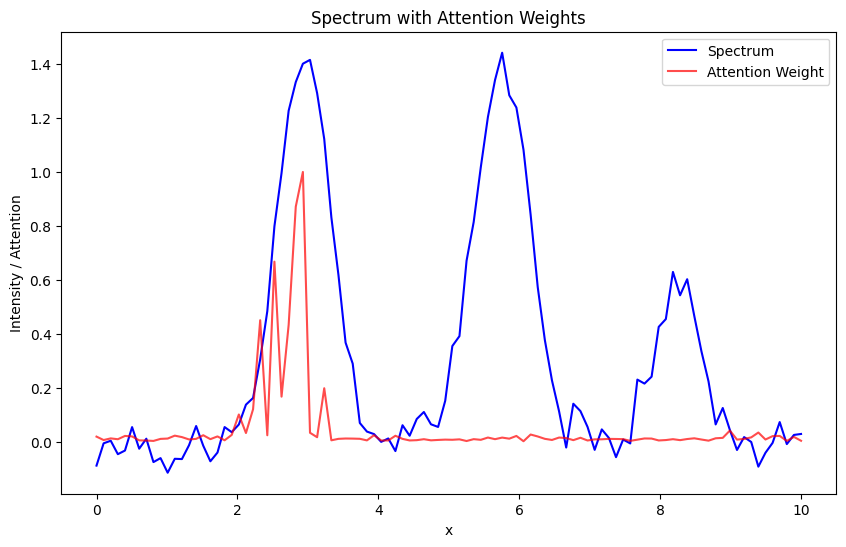

Peak positions: [3.03030303 5.75757576 8.18181818 8.38383838]
Attention at peaks: [0.03340271 0.01556297 0.00967768 0.01020548]



In [29]:
# Test the model on a few examples from the validation set
for i in range(3):
    print(f"Sample {i+1} - True A1: {y_val[i]:.4f}")
    spectrum = X_val[i]

    # Get model prediction
    with torch.no_grad():
        model.eval()
        pred = model(torch.FloatTensor(spectrum).unsqueeze(0))
        print(f"Predicted A1: {pred.item():.4f}")

    # Visualize attention
    attention_weights = visualize_attention(model, spectrum)

    # Find peaks in the spectrum and compare with attention
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(spectrum, height=0.3)

    print(f"Peak positions: {x_range[peaks]}")
    print(f"Attention at peaks: {attention_weights[peaks]}")
    print()

## Conclusion!
- The model shown that for target A1, A2 and A3 (chosen one at a time) it is able to attend to their peaks respectively